In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
torch.__version__

'0.4.0'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [6]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [7]:
batch_size = 100

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [9]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [10]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [11]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [12]:
np.max(train_dataset_labelled)

255

In [13]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [14]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

**CAE**

In [15]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [16]:
class GeneratorConditioned(nn.Module):
    def __init__(self, input_shape, output_dim=512, noise_magnitude=0.0):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2] # [3 x 32 x 32]
        self.noise_magnitude = noise_magnitude

        self.image_processor = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, 4, padding=2, stride=2), # [128 x 17 x 17]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, padding=2, stride=2), # [256 x 9 x 9]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 5, padding=2, stride=2), # [512 x 5 x 5]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 5, padding=2, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3),
            nn.Linear(1024 * 3 * 3, output_dim) # [output_dim]
        )

    def forward(self, X, Z=None):
        if Z is None:
            Z = torch.normal(mean=torch.zeros_like(X)) * self.noise_magnitude
        return self.image_processor(X + Z)

In [17]:
class CAE(nn.Module):
    def __init__(self, input_shape, latent_dim):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.proposal_generator = GeneratorConditioned(input_shape, output_dim=latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 4 * 4),
            ReshapeLayer(1024, 4, 4), # [1024 x 4 x 4]
            nn.ConvTranspose2d(1024, 512, 5, padding=1, stride=2), # [512 x 9 x 9]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 5, padding=2, stride=2), # [256 x 17 x 17]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=2, stride=2), # [128 x 32 x 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 3, 1), # [3 x 32 x 32]
            #nn.Sigmoid()
        )

    def sample_latent(self, X):
        return self.proposal_generator(X)

    def generative_distr(self, z):
        return self.generative_network(z)

    def batch_loss(self, X, return_reconstruction_loss=True, return_contraction_loss=True): 
        n = X.shape[0]
        if return_contraction_loss:
            X.requires_grad_()
            Z = self.sample_latent(X)
            k = np.random.choice(self.latent_dim)
            jacobian_k = autograd.grad([torch.sum(Z[:, k])], [X], create_graph=True)[0]
            contractive_loss = torch.sum(jacobian_k ** 2) / n
        else:
            Z = self.sample_latent(X)
            contractive_loss = None
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z)
            reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            #reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        else:
            reconstruction_loss = None
        return reconstruction_loss, contractive_loss


In [18]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(np.transpose(x.data[i].to(torch.device('cpu')).numpy(), axes=(1,2,0)), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

Epoch 1 of 50 took 100.77s;
train reconstruction loss: 14.09; test reconstruction loss: 27.41
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 2 of 50 took 100.96s;
train reconstruction loss: 14.04; test reconstruction loss: 27.44
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 3 of 50 took 100.95s;
train reconstruction loss: 13.99; test reconstruction loss: 27.48
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 4 of 50 took 100.96s;
train reconstruction loss: 13.94; test reconstruction loss: 27.44
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 5 of 50 took 100.86s;
train reconstruction loss: 13.91; test reconstruction loss: 27.57
train contraction loss: 0.02; test contraction loss: 0.00



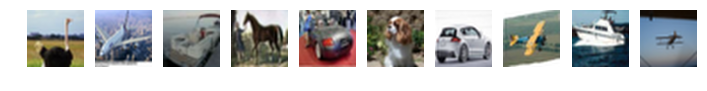

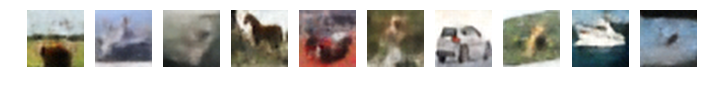

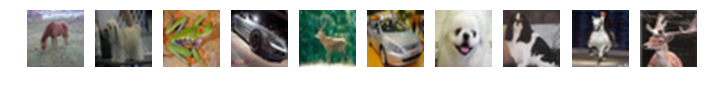

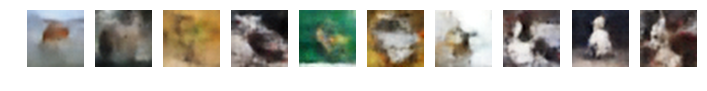

Epoch 6 of 50 took 100.74s;
train reconstruction loss: 13.88; test reconstruction loss: 27.64
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 7 of 50 took 100.43s;
train reconstruction loss: 13.88; test reconstruction loss: 27.51
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 8 of 50 took 100.22s;
train reconstruction loss: 13.85; test reconstruction loss: 27.62
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 9 of 50 took 100.55s;
train reconstruction loss: 13.78; test reconstruction loss: 27.70
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 10 of 50 took 100.73s;
train reconstruction loss: 13.75; test reconstruction loss: 27.72
train contraction loss: 0.02; test contraction loss: 0.00



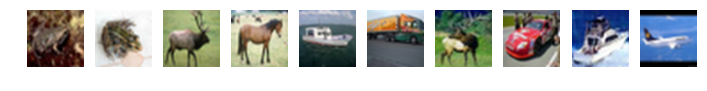

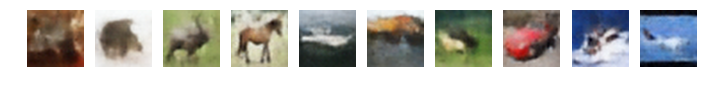

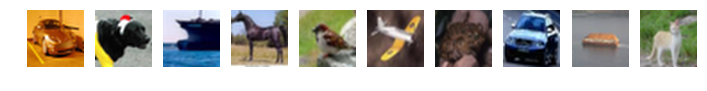

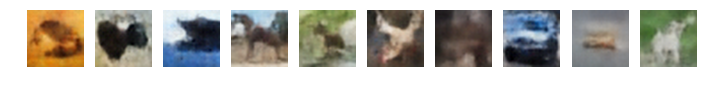

Epoch 11 of 50 took 100.71s;
train reconstruction loss: 13.71; test reconstruction loss: 27.75
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 12 of 50 took 100.75s;
train reconstruction loss: 13.71; test reconstruction loss: 27.64
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 13 of 50 took 100.71s;
train reconstruction loss: 13.67; test reconstruction loss: 27.97
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 14 of 50 took 100.74s;
train reconstruction loss: 13.65; test reconstruction loss: 27.69
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 15 of 50 took 100.71s;
train reconstruction loss: 13.61; test reconstruction loss: 28.12
train contraction loss: 0.02; test contraction loss: 0.00



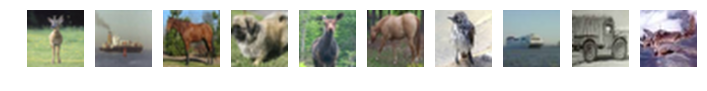

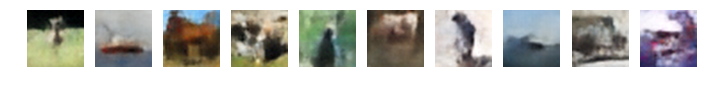

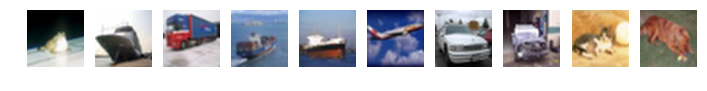

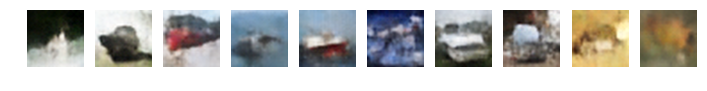

Epoch 16 of 50 took 100.72s;
train reconstruction loss: 13.59; test reconstruction loss: 27.65
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 17 of 50 took 100.73s;
train reconstruction loss: 13.58; test reconstruction loss: 28.06
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 18 of 50 took 100.77s;
train reconstruction loss: 13.55; test reconstruction loss: 27.73
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 19 of 50 took 100.75s;
train reconstruction loss: 13.52; test reconstruction loss: 27.96
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 20 of 50 took 100.72s;
train reconstruction loss: 13.51; test reconstruction loss: 28.04
train contraction loss: 0.02; test contraction loss: 0.00



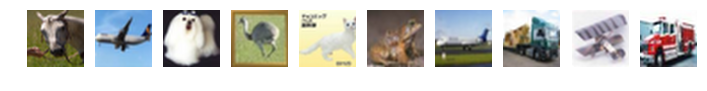

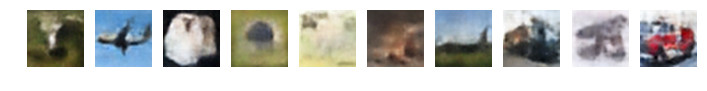

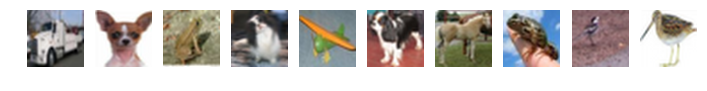

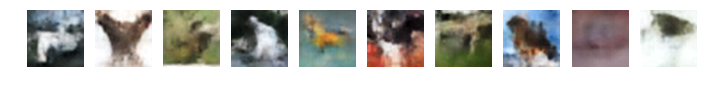

Epoch 21 of 50 took 100.72s;
train reconstruction loss: 13.50; test reconstruction loss: 28.20
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 22 of 50 took 100.73s;
train reconstruction loss: 13.46; test reconstruction loss: 27.96
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 23 of 50 took 100.76s;
train reconstruction loss: 13.43; test reconstruction loss: 27.95
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 24 of 50 took 100.72s;
train reconstruction loss: 13.43; test reconstruction loss: 28.15
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 25 of 50 took 100.75s;
train reconstruction loss: 13.37; test reconstruction loss: 28.09
train contraction loss: 0.02; test contraction loss: 0.00



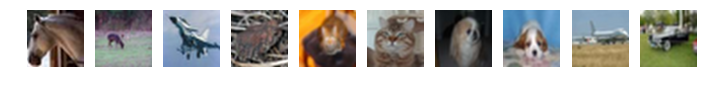

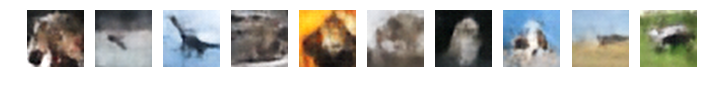

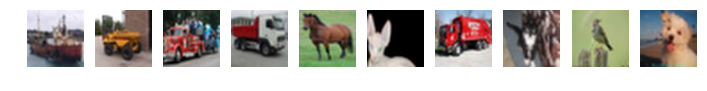

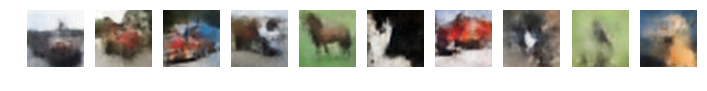

Epoch 26 of 50 took 100.73s;
train reconstruction loss: 13.34; test reconstruction loss: 28.28
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 27 of 50 took 100.78s;
train reconstruction loss: 13.34; test reconstruction loss: 28.10
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 28 of 50 took 100.78s;
train reconstruction loss: 13.29; test reconstruction loss: 28.02
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 29 of 50 took 100.87s;
train reconstruction loss: 13.29; test reconstruction loss: 28.32
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 30 of 50 took 100.86s;
train reconstruction loss: 13.27; test reconstruction loss: 28.45
train contraction loss: 0.02; test contraction loss: 0.00



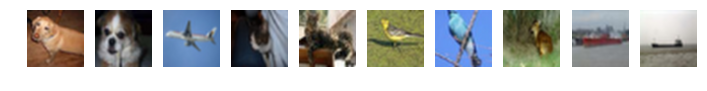

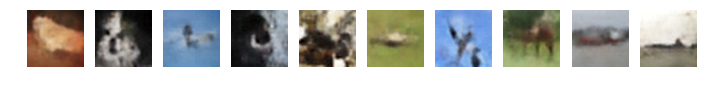

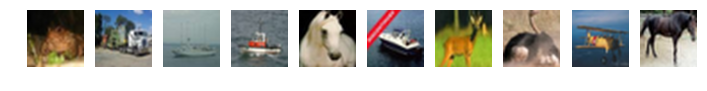

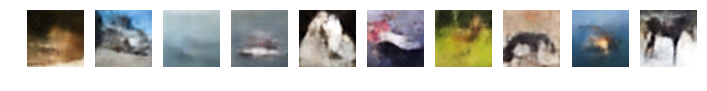

Process Process-186:
Traceback (most recent call last):
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [20]:
latent_dim = 64

num_epochs = 50
save_every = 10

name_prefix = 'cae_results/'

#try:
if True:
    #vae = cuda_wrapper(VAE(latent_dim, input_shape))
    #vae.load_state_dict(torch.load(name_prefix + 'vae.pt'))
    #print("Found pretrained VAE")
#except:
    #print("Didn't found pretrained VAE; training...")
    
    #cae = CAE(input_shape, latent_dim).to(device)
    #optimizer = optim.Adam(cae.parameters(), lr=3e-4, betas=(0.5, 0.999))

    #scheduler = optim.lr_scheduler.LambdaLR(
    #    optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    #)

    for epoch in range(num_epochs):
        start_time = time()
        
        scheduler.step()
        
        regularization_factor = 10

        cum_loss_reconstruction = 0
        cum_loss_contraction = 0
        batch_count = 0
        
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            loss_reconstruction, loss_contraction = cae.batch_loss(X_batch)
            cum_loss_reconstruction += loss_reconstruction.item()
            cum_loss_contraction += loss_contraction.item()
                
            optimizer.zero_grad()
            (loss_reconstruction + loss_contraction * regularization_factor).backward()
            optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_train_loss_contraction = cum_loss_contraction / batch_count

        cum_loss_reconstruction = 0
        cum_loss_contraction = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction, _ = cae.batch_loss(X_batch, return_contraction_loss=False)
                cum_loss_reconstruction += loss_reconstruction.item()
                #cum_loss_contraction += loss_contraction.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_contraction = cum_loss_contraction / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print('train contraction loss: {:.2f}; test contraction loss: {:.2f}'.format(
            mean_train_loss_contraction, mean_test_loss_contraction
        ))
        print()
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(train_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                cae.generative_network(
                    cae.proposal_generator(X_batch)
                )
            )
            plt.show()
            X_batch = next(iter(test_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                cae.generative_network(
                    cae.proposal_generator(X_batch)
                )
            )
            plt.show()
    
        if (epoch+1) % save_every == 0:
            torch.save(cae.state_dict(), name_prefix + 'cae.pt')
        


**Tangent prop**

In [21]:
def constrain_loss_function(model, generative_model, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = torch.normal(std=torch.ones(batch_size, latent_dim, device=device)) # [batch_size x latent_dim]
            X_gen = generative_model.generative_distr(z_gen).detach().requires_grad_() # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = X_gen.to(device).requires_grad_()
        z_inferred = generative_model.sample_latent(X_gen) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = torch.normal(
                std=torch.ones(batch_size, latent_dim, device=device)
            ).requires_grad_() # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = X.to(device)
            z_inferred = generative_model.sample_latent(X).detach().requires_grad_() # [batch_size x latent_dim]
    X_inferred = generative_model.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [22]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [23]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [ ]:
num_epochs = 200
save_every = 10

modes = ['stochastic_manifold_reg_on_train_data__eta=' + str(eta) for eta in [0, 1e-5, 1e-4, 1e-3, 1e-2]]

loss_function = nn.NLLLoss()

for mode in modes:
    mode_name = mode + '__labelled=4000__epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    model = ModelConvolutional(input_shape, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
    for epoch in range(num_epochs):
        start_time = time()
    
        #scheduler.step()
    
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_loss_full = 0
        cum_acc = 0
        batch_count = 0

        model.train()
        train_iter_unlabelled = iter(train_loader_unlabelled)
        for X, y in train_loader_labelled:
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.item()
        
            loss_constrain = constrain_loss_function(
                model, cae, reparam_invariant=True, use_all_classes=False, batch_gen=train_iter_unlabelled
            )
            cum_loss_constrain += loss_constrain.item()
        
            loss_full = loss_data + eta * loss_constrain
            cum_loss_full += loss_full.item()
            
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.item()
        
            optimizer.zero_grad()
            loss_full.backward()
            optimizer.step()
            batch_count += 1
            
        mean_train_loss_data = cum_loss_data / batch_count
        mean_train_loss_constrain = cum_loss_constrain / batch_count
        mean_train_loss_full = cum_loss_full / batch_count
        mean_train_acc = cum_acc / batch_count

        train_losses[mode].append(mean_train_loss_data)
        train_accs[mode].append(mean_train_acc)
        
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_acc = 0
        batch_count = 0

        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                batch_count += 1
            
        mean_test_loss_data = cum_loss_data / batch_count
        mean_test_loss_constrain = cum_loss_constrain / batch_count
        mean_test_acc = cum_acc / batch_count

        test_losses[mode].append(mean_test_loss_data)
        test_accs[mode].append(mean_test_acc)
        
        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
            )
        )
        print('train acc: {:.2f}'.format(mean_train_acc*100))
        print('test loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}'.format(
                mean_test_loss_data, mean_test_loss_constrain
            )
        )
        print('test acc: {:.2f}'.format(mean_test_acc*100))
        print()
        
        if (epoch+1) % save_every == 0:
            with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                pickle.dump(np.array(train_losses[mode]), f)
            with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                pickle.dump(np.array(test_losses[mode]), f)
            with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                pickle.dump(np.array(train_accs[mode]), f)
            with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                pickle.dump(np.array(test_accs[mode]), f)

            torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')



Mode: stochastic_manifold_reg_on_train_data__eta=0
stochastic_manifold_reg_on_train_data__eta=0__labelled=4000__epochs=200
eta = 0.0

Epoch 1 of 200 took 24.30s;
train loss:
data term: 2.03, constrain term: 0.03, full: 2.03
train acc: 25.25
test loss:
data term: 2.11, constrain term: 0.00
test acc: 21.65

Epoch 2 of 200 took 24.31s;
train loss:
data term: 1.82, constrain term: 0.14, full: 1.82
train acc: 35.15
test loss:
data term: 2.19, constrain term: 0.00
test acc: 21.41

Epoch 3 of 200 took 24.32s;
train loss:
data term: 1.71, constrain term: 0.35, full: 1.71
train acc: 38.02
test loss:
data term: 2.01, constrain term: 0.00
test acc: 24.07

Epoch 4 of 200 took 24.32s;
train loss:
data term: 1.64, constrain term: 0.54, full: 1.64
train acc: 41.25
test loss:
data term: 1.87, constrain term: 0.00
test acc: 29.49

Epoch 5 of 200 took 24.32s;
train loss:
data term: 1.58, constrain term: 0.82, full: 1.58
train acc: 42.77
test loss:
data term: 1.98, constrain term: 0.00
test acc: 28.21

E

Epoch 48 of 200 took 24.41s;
train loss:
data term: 0.53, constrain term: 43.90, full: 0.53
train acc: 82.63
test loss:
data term: 1.32, constrain term: 0.00
test acc: 56.35

Epoch 49 of 200 took 24.39s;
train loss:
data term: 0.50, constrain term: 45.73, full: 0.50
train acc: 84.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 56.33

Epoch 50 of 200 took 24.32s;
train loss:
data term: 0.49, constrain term: 45.84, full: 0.49
train acc: 84.57
test loss:
data term: 1.49, constrain term: 0.00
test acc: 54.86

Epoch 51 of 200 took 24.45s;
train loss:
data term: 0.47, constrain term: 48.79, full: 0.47
train acc: 85.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 61.28

Epoch 52 of 200 took 24.32s;
train loss:
data term: 0.45, constrain term: 50.22, full: 0.45
train acc: 86.02
test loss:
data term: 1.08, constrain term: 0.00
test acc: 63.66

Epoch 53 of 200 took 24.31s;
train loss:
data term: 0.43, constrain term: 55.25, full: 0.43
train acc: 86.20
test loss:
data 

Epoch 95 of 200 took 24.35s;
train loss:
data term: 0.12, constrain term: 179.03, full: 0.12
train acc: 97.10
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.77

Epoch 96 of 200 took 24.41s;
train loss:
data term: 0.12, constrain term: 178.90, full: 0.12
train acc: 96.60
test loss:
data term: 1.33, constrain term: 0.00
test acc: 63.63

Epoch 97 of 200 took 24.40s;
train loss:
data term: 0.13, constrain term: 179.34, full: 0.13
train acc: 96.38
test loss:
data term: 1.19, constrain term: 0.00
test acc: 66.09

Epoch 98 of 200 took 24.41s;
train loss:
data term: 0.13, constrain term: 184.90, full: 0.13
train acc: 96.70
test loss:
data term: 1.28, constrain term: 0.00
test acc: 64.35

Epoch 99 of 200 took 24.40s;
train loss:
data term: 0.12, constrain term: 184.30, full: 0.12
train acc: 96.90
test loss:
data term: 1.23, constrain term: 0.00
test acc: 66.16



In [57]:
from pandas import ewma, DataFrame

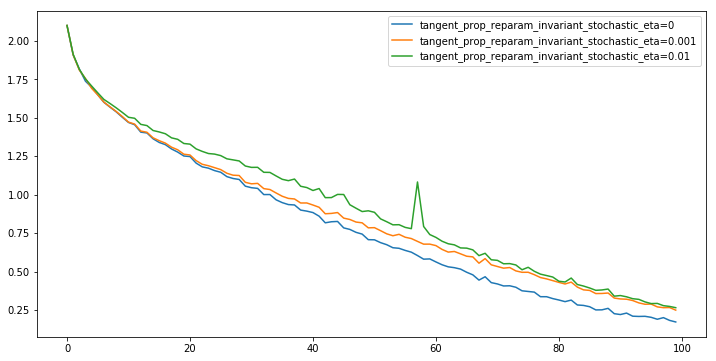

In [65]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_losses[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


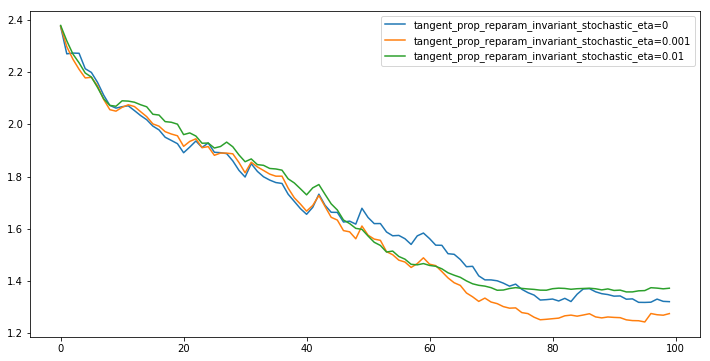

In [66]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_losses[mode]), alpha=0.1))
plt.legend(modes)

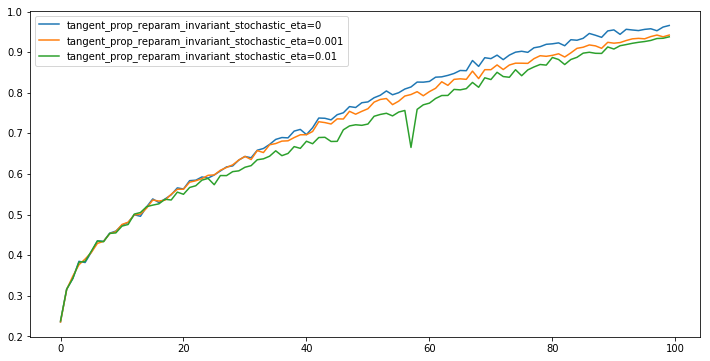

In [67]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_accs[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


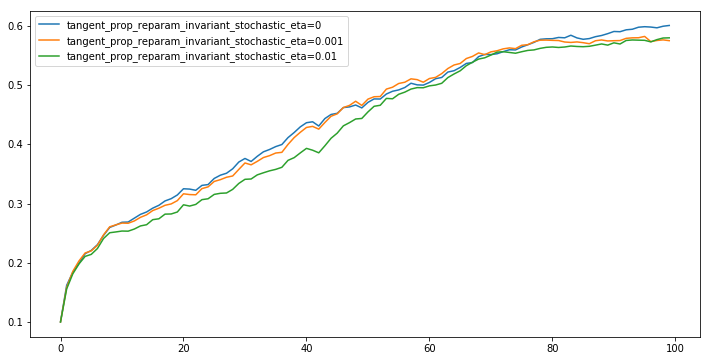

In [68]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_accs[mode]), alpha=0.1))
plt.legend(modes)